# EN3150 Assignment 3 — Part 1: Custom CNN

Train a simple CNN on RealWaste (9 classes), try a few optimizers, check results. PyTorch, nothing fancy.

## 1) Setup

In [39]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time
import warnings

warnings.filterwarnings('ignore')

torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.backends.cudnn.deterministic = True

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.8.0+cu126
CUDA available: True


## 2) Config

In [40]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 9
EPOCHS = 20
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
SPLIT_DATA_DIR = 'dataloader'

RESULTS_DIR = 'results'
MODELS_DIR = os.path.join(RESULTS_DIR, 'models')
VIZ_DIR = os.path.join(RESULTS_DIR, 'visualizations')
PART1_DIR = os.path.join(RESULTS_DIR, 'part1')
PART2_DIR = os.path.join(RESULTS_DIR, 'part2')

for directory in [RESULTS_DIR, MODELS_DIR, VIZ_DIR, PART1_DIR, PART2_DIR]:
    os.makedirs(directory, exist_ok=True)

## 3) Data

In [41]:
def get_data_loaders():
    train_transform = transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    val_test_transform = transforms.Compose([
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    train_dataset = datasets.ImageFolder(
        root=os.path.join(SPLIT_DATA_DIR, 'train'),
        transform=train_transform
    )
    
    val_dataset = datasets.ImageFolder(
        root=os.path.join(SPLIT_DATA_DIR, 'val'),
        transform=val_test_transform
    )
    
    test_dataset = datasets.ImageFolder(
        root=os.path.join(SPLIT_DATA_DIR, 'test'),
        transform=val_test_transform
    )
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    
    return train_loader, val_loader, test_loader, train_dataset.classes

train_loader, val_loader, test_loader, class_names = get_data_loaders()

# print(f"Training samples: {len(train_loader.dataset)}")
# print(f"Validation samples: {len(val_loader.dataset)}")
# print(f"Test samples: {len(test_loader.dataset)}")
print(f"Classes: {class_names}")

Classes: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']


## 4) Model
Small CNN: 3 conv blocks + 2 FC. Dropout + BN. Gets the job done.

In [42]:
class WasteCustom(nn.Module):
    def __init__(self, num_classes=9):
        super(WasteCustom, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.flatten = nn.Flatten()
        self.adaptive_pool = nn.AdaptiveAvgPool2d((8, 8))
        
        self.fc1 = nn.Linear(8192, 512)
        self.dropout1 = nn.Dropout(p=0.3)
        
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.LeakyReLU()
    
    def forward(self, x):
        x = self.pool1(self.relu(self.conv1(x)))
        x = self.pool2(self.relu(self.conv2(x)))
        x = self.pool3(self.relu(self.conv3(x)))
        x = self.adaptive_pool(x)
        x = self.flatten(x)
        x = self.dropout1(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model = WasteCustom(num_classes=NUM_CLASSES).to(DEVICE)
total_params = sum(p.numel() for p in model.parameters())

print(f"Total Parameters: {total_params:,}")
print("Architecture: 3 Conv blocks + 2 FC layers (no BN)")

Total Parameters: 4,292,681
Architecture: 3 Conv blocks + 2 FC layers (no BN)


## 5) Train utils

In [43]:
def train_one_epoch(model, dataloader, criterion, optimizer, device, current_lr, show_progress=False):
    model.train()
    running_loss, running_correct, total = 0.0, 0, 0
    batch_losses, batch_accs = [], []

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_loss = loss.item()
        batch_losses.append(batch_loss)

        _, preds = torch.max(outputs, 1)
        batch_correct = (preds == labels).sum().item()
        batch_acc = batch_correct / inputs.size(0)
        batch_accs.append(batch_acc)

        running_loss += loss.item() * inputs.size(0)
        running_correct += batch_correct
        total += inputs.size(0)

    epoch_loss = running_loss / total
    epoch_acc = running_correct / total
    return epoch_loss, epoch_acc


def validate(model, dataloader, criterion, device, show_progress=False):
    model.eval()
    running_loss, running_correct, total = 0.0, 0, 0

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_correct += (preds == labels).sum().item()
            total += inputs.size(0)

    epoch_loss = running_loss / total
    epoch_acc = running_correct / total
    return epoch_loss, epoch_acc

In [44]:
def train_model(model, train_loader, val_loader, optimizer, criterion, epochs, device, model_name, use_scheduler=True):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'learning_rates': []}
    best_val_acc = 0.0
    scheduler = None
    if use_scheduler:
        scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer, T_0=20, T_mult=1, eta_min=1e-6
        )

    for epoch in range(epochs):
        lr = optimizer.param_groups[0]['lr']
        history['learning_rates'].append(lr)

        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, lr)
        val_loss, val_acc = validate(model, val_loader, criterion, device)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        if scheduler is not None:
            scheduler.step()

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), os.path.join(MODELS_DIR, f'best_model_{model_name}.pth'))

        print(f"epoch {epoch+1:02d}/{epochs} | lr {lr:.6f} | train {train_loss:.4f}/{train_acc:.4f} | val {val_loss:.4f}/{val_acc:.4f}")

    print(f"best val acc: {best_val_acc:.4f} -> saved: {os.path.join(MODELS_DIR, f'best_model_{model_name}.pth')}")
    return history, best_val_acc

## 6) Train: Adam

In [45]:
model_adam = WasteCustom(num_classes=NUM_CLASSES).to(DEVICE)
optimizer_adam = optim.Adam(model_adam.parameters(), lr=0.0005, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

adam_history, adam_best_acc = train_model(
    model=model_adam,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer_adam,
    criterion=criterion,
    epochs=EPOCHS,
    device=DEVICE,
    model_name='WasteCustom_Adam',
    use_scheduler=True
)

epoch 01/20 | lr 0.000500 | train 1.7363/0.3783 | val 1.3842/0.5131
epoch 02/20 | lr 0.000497 | train 1.2981/0.5277 | val 1.0810/0.6236
epoch 03/20 | lr 0.000488 | train 1.1344/0.5871 | val 0.9686/0.6515
epoch 04/20 | lr 0.000473 | train 1.0160/0.6301 | val 0.8312/0.6986
epoch 05/20 | lr 0.000452 | train 0.9239/0.6576 | val 0.7267/0.7538
epoch 06/20 | lr 0.000427 | train 0.8447/0.6855 | val 0.7245/0.7276
epoch 07/20 | lr 0.000397 | train 0.8091/0.7041 | val 0.6428/0.7763
epoch 08/20 | lr 0.000364 | train 0.7253/0.7399 | val 0.5513/0.8025
epoch 09/20 | lr 0.000328 | train 0.6669/0.7583 | val 0.5868/0.8003
epoch 10/20 | lr 0.000290 | train 0.6151/0.7821 | val 0.4830/0.8271
epoch 11/20 | lr 0.000251 | train 0.5741/0.7972 | val 0.4441/0.8408
epoch 12/20 | lr 0.000211 | train 0.5303/0.8074 | val 0.4222/0.8545
epoch 13/20 | lr 0.000173 | train 0.4865/0.8238 | val 0.3662/0.8824
epoch 14/20 | lr 0.000137 | train 0.4506/0.8374 | val 0.3219/0.8917
epoch 15/20 | lr 0.000104 | train 0.4358/0.8478 

## 7) Train: SGD

In [46]:
model_sgd = WasteCustom(num_classes=NUM_CLASSES).to(DEVICE)
optimizer_sgd = optim.SGD(model_sgd.parameters(), lr=0.01000, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

sgd_history, sgd_best_acc = train_model(
    model=model_sgd,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer_sgd,
    criterion=criterion,
    epochs=EPOCHS,
    device=DEVICE,
    model_name='WasteCustom_SGD',
    use_scheduler=True
)

epoch 01/20 | lr 0.010000 | train 2.1456/0.1989 | val 2.1071/0.2117
epoch 02/20 | lr 0.009938 | train 2.0505/0.2469 | val 1.9309/0.3397
epoch 03/20 | lr 0.009755 | train 1.8933/0.3206 | val 1.8058/0.3414
epoch 04/20 | lr 0.009455 | train 1.7571/0.3694 | val 1.7583/0.3474
epoch 05/20 | lr 0.009045 | train 1.6710/0.3988 | val 1.6151/0.4240
epoch 06/20 | lr 0.008536 | train 1.6126/0.4241 | val 1.5063/0.4759
epoch 07/20 | lr 0.007939 | train 1.5403/0.4475 | val 1.4514/0.4885
epoch 08/20 | lr 0.007270 | train 1.4892/0.4732 | val 1.3882/0.5109
epoch 09/20 | lr 0.006545 | train 1.4357/0.4894 | val 1.3631/0.5317
epoch 10/20 | lr 0.005783 | train 1.4069/0.4965 | val 1.3307/0.5454
epoch 11/20 | lr 0.005001 | train 1.3595/0.5123 | val 1.2983/0.5470
epoch 12/20 | lr 0.004218 | train 1.3241/0.5264 | val 1.2716/0.5498
epoch 13/20 | lr 0.003456 | train 1.3004/0.5476 | val 1.2338/0.5618
epoch 14/20 | lr 0.002731 | train 1.2694/0.5480 | val 1.2211/0.5771
epoch 15/20 | lr 0.002062 | train 1.2439/0.5504 

## 8) Train: SGD+Momentum

In [47]:
model_sgd_momentum = WasteCustom(num_classes=NUM_CLASSES).to(DEVICE)
optimizer_sgd_momentum = optim.SGD(model_sgd_momentum.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

sgd_momentum_history, sgd_momentum_best_acc = train_model(
    model=model_sgd_momentum,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer_sgd_momentum,
    criterion=criterion,
    epochs=EPOCHS,
    device=DEVICE,
    model_name='WasteCustom_SGD_Momentum',
    use_scheduler=True
)

epoch 01/20 | lr 0.010000 | train 2.0004/0.2659 | val 1.7089/0.3310
epoch 02/20 | lr 0.009938 | train 1.6350/0.3932 | val 1.5550/0.4261
epoch 03/20 | lr 0.009755 | train 1.5192/0.4486 | val 1.3659/0.4869
epoch 04/20 | lr 0.009455 | train 1.4048/0.4890 | val 1.4652/0.4584
epoch 05/20 | lr 0.009045 | train 1.3725/0.5119 | val 1.3008/0.5219
epoch 06/20 | lr 0.008536 | train 1.2591/0.5523 | val 1.3584/0.5284
epoch 07/20 | lr 0.007939 | train 1.1914/0.5705 | val 1.0762/0.6149
epoch 08/20 | lr 0.007270 | train 1.0958/0.6113 | val 1.0031/0.6291
epoch 09/20 | lr 0.006545 | train 1.0308/0.6230 | val 0.9603/0.6466
epoch 10/20 | lr 0.005783 | train 0.9477/0.6582 | val 0.8770/0.6789
epoch 11/20 | lr 0.005001 | train 0.8782/0.6840 | val 0.7030/0.7407
epoch 12/20 | lr 0.004218 | train 0.7917/0.7067 | val 0.6428/0.7670
epoch 13/20 | lr 0.003456 | train 0.7466/0.7307 | val 0.6495/0.7670
epoch 14/20 | lr 0.002731 | train 0.6815/0.7577 | val 0.5618/0.8085
epoch 15/20 | lr 0.002062 | train 0.6345/0.7700 

## 9) Optimizer curves

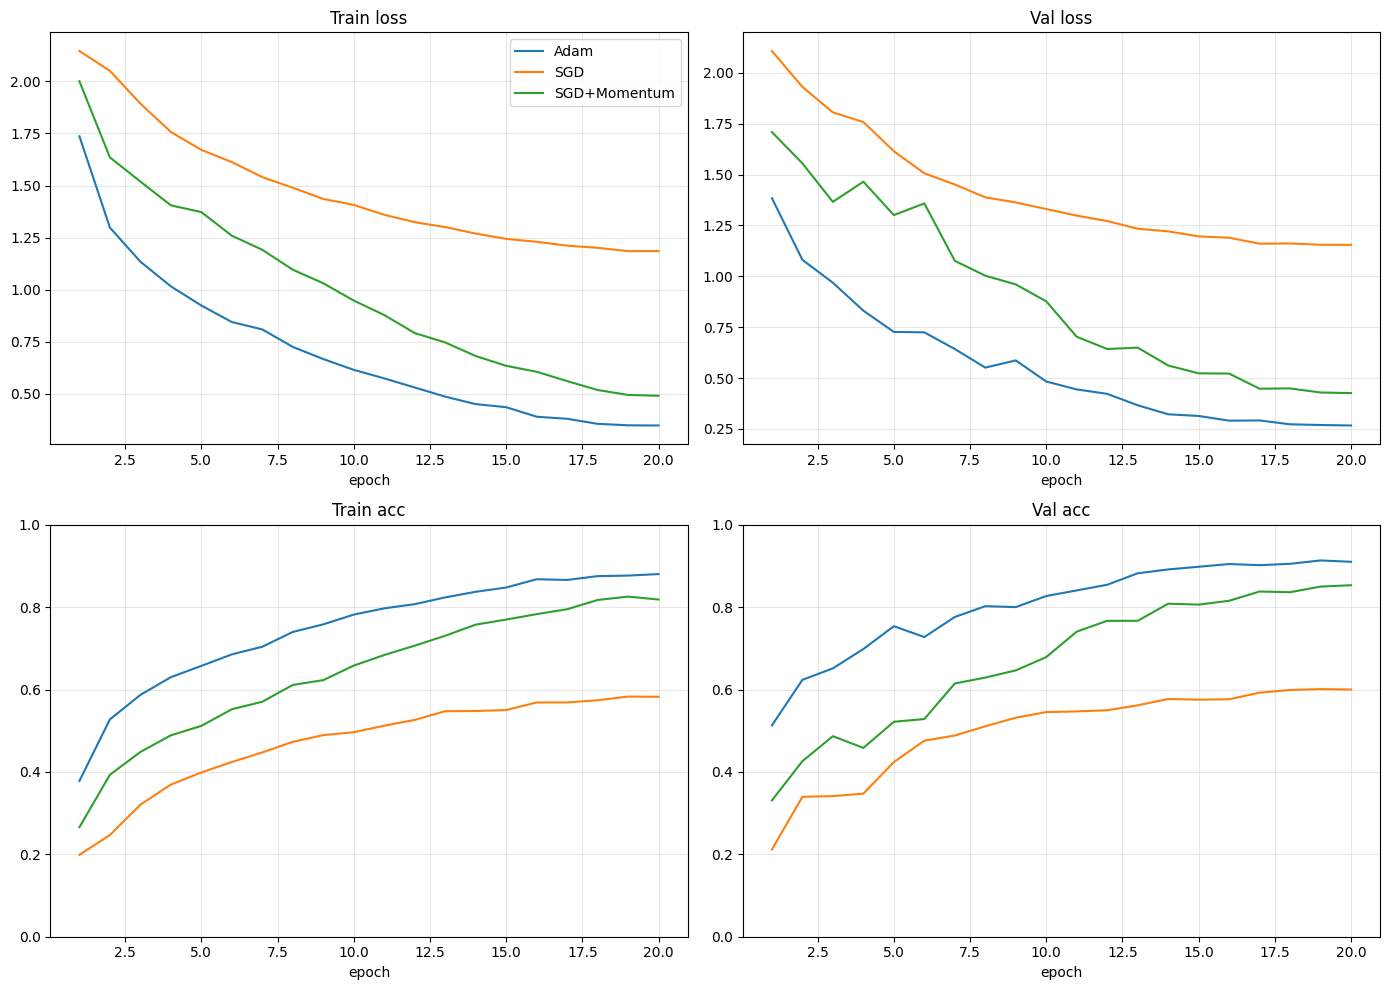

In [48]:
def plot_optimizer_comparison(histories, names, save_path=None):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    epochs = range(1, len(histories[0]['train_loss']) + 1)

    for h, n in zip(histories, names):
        axes[0, 0].plot(epochs, h['train_loss'], label=n)
    axes[0, 0].set_title('Train loss')

    for h, n in zip(histories, names):
        axes[0, 1].plot(epochs, h['val_loss'], label=n)
    axes[0, 1].set_title('Val loss')

    for h, n in zip(histories, names):
        axes[1, 0].plot(epochs, h['train_acc'], label=n)
    axes[1, 0].set_title('Train acc')
    axes[1, 0].set_ylim([0, 1])

    for h, n in zip(histories, names):
        axes[1, 1].plot(epochs, h['val_acc'], label=n)
    axes[1, 1].set_title('Val acc')
    axes[1, 1].set_ylim([0, 1])

    for ax in axes.ravel():
        ax.grid(True, alpha=0.3)
        ax.set_xlabel('epoch')

    axes[0, 0].legend()
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

plot_optimizer_comparison(
    histories=[adam_history, sgd_history, sgd_momentum_history],
    names=['Adam', 'SGD', 'SGD+Momentum'],
    save_path=os.path.join(PART1_DIR, 'optimizer_comparison.png')
)

## 10) Test eval (all optimizers)

In [49]:
import time

print("="*80)
print("EVALUATING ALL OPTIMIZERS ON TEST SET")
print("="*80)

# Function to evaluate model on test set
def evaluate_on_test_set(model, test_loader, criterion, device, model_name):
    """Evaluate model on test set and return metrics"""
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    
    start_time = time.time()
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    inference_time = time.time() - start_time
    
    test_accuracy = correct / total
    avg_test_loss = test_loss / total
    
    print(f"\n{model_name}:")
    print(f"  Test Accuracy:     {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
    print(f"  Test Loss:         {avg_test_loss:.4f}")
    print(f"  Inference Time:    {inference_time:.2f}s")
    print(f"  Correct/Total:     {correct}/{total}")
    
    return test_accuracy, avg_test_loss, inference_time

# Define criterion for evaluation
criterion = nn.CrossEntropyLoss()

# Evaluate Adam Model
adam_test_acc, adam_test_loss, adam_inference_time = evaluate_on_test_set(
    model_adam, test_loader, criterion, DEVICE, "Adam Optimizer"
)

# Evaluate SGD Model
sgd_test_acc, sgd_test_loss, sgd_inference_time = evaluate_on_test_set(
    model_sgd, test_loader, criterion, DEVICE, "SGD Optimizer"
)

# Evaluate SGD with Momentum Model
sgd_mom_test_acc, sgd_mom_test_loss, sgd_mom_inference_time = evaluate_on_test_set(
    model_sgd_momentum, test_loader, criterion, DEVICE, "SGD with Momentum"
)

print("\n" + "="*80)
print("TEST SET EVALUATION COMPLETED")
print("="*80)

EVALUATING ALL OPTIMIZERS ON TEST SET

Adam Optimizer:
  Test Accuracy:     0.9247 (92.47%)
  Test Loss:         0.2541
  Inference Time:    16.49s
  Correct/Total:     1719/1859

SGD Optimizer:
  Test Accuracy:     0.6132 (61.32%)
  Test Loss:         1.1282
  Inference Time:    14.13s
  Correct/Total:     1140/1859

SGD with Momentum:
  Test Accuracy:     0.8531 (85.31%)
  Test Loss:         0.4116
  Inference Time:    14.29s
  Correct/Total:     1586/1859

TEST SET EVALUATION COMPLETED


### Metrics

In [50]:
# Collect comprehensive metrics for all three optimizers
optimizer_comparison = {
    'Adam': {
        'test_accuracy': adam_test_acc,
        'test_loss': adam_test_loss,
        'final_train_acc': adam_history['train_acc'][-1],
        'final_val_acc': adam_history['val_acc'][-1],
        'best_val_acc': max(adam_history['val_acc']),
        'final_train_loss': adam_history['train_loss'][-1],
        'final_val_loss': adam_history['val_loss'][-1],
        'epochs_trained': len(adam_history['train_acc']),
        'inference_time': adam_inference_time,
        'train_val_acc_gap': adam_history['train_acc'][-1] - adam_history['val_acc'][-1],
        'train_test_acc_gap': adam_history['train_acc'][-1] - adam_test_acc
    },
    'SGD': {
        'test_accuracy': sgd_test_acc,
        'test_loss': sgd_test_loss,
        'final_train_acc': sgd_history['train_acc'][-1],
        'final_val_acc': sgd_history['val_acc'][-1],
        'best_val_acc': max(sgd_history['val_acc']),
        'final_train_loss': sgd_history['train_loss'][-1],
        'final_val_loss': sgd_history['val_loss'][-1],
        'epochs_trained': len(sgd_history['train_acc']),
        'inference_time': sgd_inference_time,
        'train_val_acc_gap': sgd_history['train_acc'][-1] - sgd_history['val_acc'][-1],
        'train_test_acc_gap': sgd_history['train_acc'][-1] - sgd_test_acc
    },
    'SGD + Momentum': {
        'test_accuracy': sgd_mom_test_acc,
        'test_loss': sgd_mom_test_loss,
        'final_train_acc': sgd_momentum_history['train_acc'][-1],
        'final_val_acc': sgd_momentum_history['val_acc'][-1],
        'best_val_acc': max(sgd_momentum_history['val_acc']),
        'final_train_loss': sgd_momentum_history['train_loss'][-1],
        'final_val_loss': sgd_momentum_history['val_loss'][-1],
        'epochs_trained': len(sgd_momentum_history['train_acc']),
        'inference_time': sgd_mom_inference_time,
        'train_val_acc_gap': sgd_momentum_history['train_acc'][-1] - sgd_momentum_history['val_acc'][-1],
        'train_test_acc_gap': sgd_momentum_history['train_acc'][-1] - sgd_mom_test_acc
    }
}

print("\nMetrics collected successfully for all optimizers!")


Metrics collected successfully for all optimizers!


### Compare at a glance

In [51]:
print("== Optimizer comparison ==")
print(f"{'opt':<18} {'test_acc':<10} {'test_loss':<10} {'inference(s)':<12}")
for opt, m in optimizer_comparison.items():
    print(f"{opt:<18} {m['test_accuracy']:.4f} {m['test_loss']:.4f} {m['inference_time']:.2f}")

best_test_acc = max(optimizer_comparison.items(), key=lambda x: x[1]['test_accuracy'])
best_test_loss = min(optimizer_comparison.items(), key=lambda x: x[1]['test_loss'])
best_generalization = min(optimizer_comparison.items(), key=lambda x: x[1]['train_test_acc_gap'])
fastest_inference = min(optimizer_comparison.items(), key=lambda x: x[1]['inference_time'])

print("\nBest:")
print(f"acc -> {best_test_acc[0]} ({best_test_acc[1]['test_accuracy']*100:.2f}%)")
print(f"loss -> {best_test_loss[0]} ({best_test_loss[1]['test_loss']:.4f})")
print(f"gen  -> {best_generalization[0]} (gap {best_generalization[1]['train_test_acc_gap']:.4f})")
print(f"speed-> {fastest_inference[0]} ({fastest_inference[1]['inference_time']:.2f}s)")

== Optimizer comparison ==
opt                test_acc   test_loss  inference(s)
Adam               0.9247 0.2541 16.49
SGD                0.6132 1.1282 14.13
SGD + Momentum     0.8531 0.4116 14.29

Best:
acc -> Adam (92.47%)
loss -> Adam (0.2541)
gen  -> Adam (gap -0.0442)
speed-> SGD (14.13s)


Comprehensive comparison plot saved to results\part1\optimizer_comparison_comprehensive.png


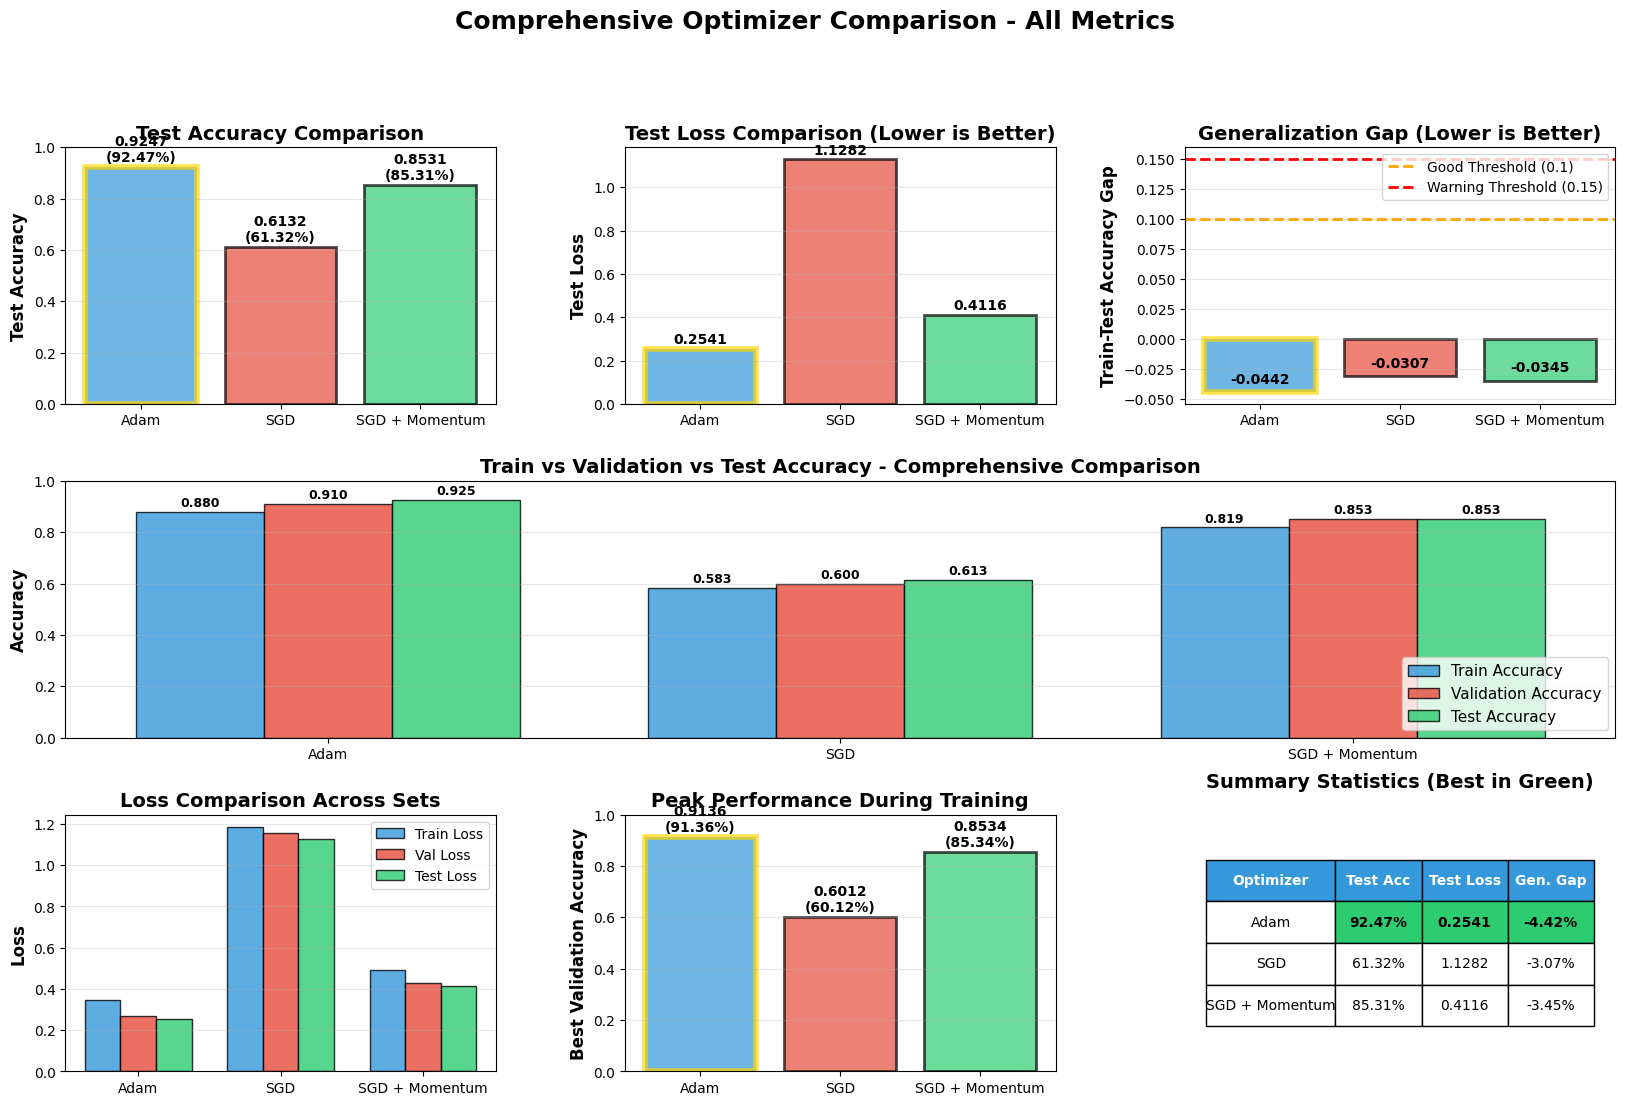

In [52]:
# Create comprehensive visual comparison
fig = plt.figure(figsize=(20, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

optimizers = list(optimizer_comparison.keys())
colors = ['#3498db', '#e74c3c', '#2ecc71']

# 1. Test Accuracy Comparison
ax1 = fig.add_subplot(gs[0, 0])
test_accs = [optimizer_comparison[opt]['test_accuracy'] for opt in optimizers]
bars = ax1.bar(optimizers, test_accs, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax1.set_ylabel('Test Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('Test Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.set_ylim([0, 1])
ax1.grid(axis='y', alpha=0.3)
for i, (bar, acc) in enumerate(zip(bars, test_accs)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{acc:.4f}\n({acc*100:.2f}%)', ha='center', va='bottom', fontweight='bold')
# Highlight best
best_idx = test_accs.index(max(test_accs))
bars[best_idx].set_edgecolor('gold')
bars[best_idx].set_linewidth(4)

# 2. Test Loss Comparison
ax2 = fig.add_subplot(gs[0, 1])
test_losses = [optimizer_comparison[opt]['test_loss'] for opt in optimizers]
bars = ax2.bar(optimizers, test_losses, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax2.set_ylabel('Test Loss', fontsize=12, fontweight='bold')
ax2.set_title('Test Loss Comparison (Lower is Better)', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
for i, (bar, loss) in enumerate(zip(bars, test_losses)):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{loss:.4f}', ha='center', va='bottom', fontweight='bold')
# Highlight best
best_idx = test_losses.index(min(test_losses))
bars[best_idx].set_edgecolor('gold')
bars[best_idx].set_linewidth(4)

# 3. Generalization Gap Comparison
ax3 = fig.add_subplot(gs[0, 2])
train_test_gaps = [optimizer_comparison[opt]['train_test_acc_gap'] for opt in optimizers]
bars = ax3.bar(optimizers, train_test_gaps, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax3.set_ylabel('Train-Test Accuracy Gap', fontsize=12, fontweight='bold')
ax3.set_title('Generalization Gap (Lower is Better)', fontsize=14, fontweight='bold')
ax3.axhline(y=0.1, color='orange', linestyle='--', linewidth=2, label='Good Threshold (0.1)')
ax3.axhline(y=0.15, color='red', linestyle='--', linewidth=2, label='Warning Threshold (0.15)')
ax3.grid(axis='y', alpha=0.3)
ax3.legend(loc='upper right')
for i, (bar, gap) in enumerate(zip(bars, train_test_gaps)):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'{gap:.4f}', ha='center', va='bottom', fontweight='bold')
# Highlight best
best_idx = train_test_gaps.index(min(train_test_gaps))
bars[best_idx].set_edgecolor('gold')
bars[best_idx].set_linewidth(4)

# 4. Training vs Validation vs Test Accuracy
ax4 = fig.add_subplot(gs[1, :])
x = np.arange(len(optimizers))
width = 0.25
train_accs = [optimizer_comparison[opt]['final_train_acc'] for opt in optimizers]
val_accs = [optimizer_comparison[opt]['final_val_acc'] for opt in optimizers]

bars1 = ax4.bar(x - width, train_accs, width, label='Train Accuracy', color='#3498db', alpha=0.8, edgecolor='black')
bars2 = ax4.bar(x, val_accs, width, label='Validation Accuracy', color='#e74c3c', alpha=0.8, edgecolor='black')
bars3 = ax4.bar(x + width, test_accs, width, label='Test Accuracy', color='#2ecc71', alpha=0.8, edgecolor='black')

ax4.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax4.set_title('Train vs Validation vs Test Accuracy - Comprehensive Comparison', fontsize=14, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(optimizers)
ax4.legend(loc='lower right', fontsize=11)
ax4.set_ylim([0, 1])
ax4.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# 5. Loss Comparison (Train vs Val vs Test)
ax5 = fig.add_subplot(gs[2, 0])
train_losses = [optimizer_comparison[opt]['final_train_loss'] for opt in optimizers]
val_losses = [optimizer_comparison[opt]['final_val_loss'] for opt in optimizers]

x_pos = np.arange(len(optimizers))
width = 0.25
ax5.bar(x_pos - width, train_losses, width, label='Train Loss', color='#3498db', alpha=0.8, edgecolor='black')
ax5.bar(x_pos, val_losses, width, label='Val Loss', color='#e74c3c', alpha=0.8, edgecolor='black')
ax5.bar(x_pos + width, test_losses, width, label='Test Loss', color='#2ecc71', alpha=0.8, edgecolor='black')
ax5.set_ylabel('Loss', fontsize=12, fontweight='bold')
ax5.set_title('Loss Comparison Across Sets', fontsize=14, fontweight='bold')
ax5.set_xticks(x_pos)
ax5.set_xticklabels(optimizers)
ax5.legend()
ax5.grid(axis='y', alpha=0.3)

# 6. Best Validation Accuracy Achieved
ax6 = fig.add_subplot(gs[2, 1])
best_val_accs = [optimizer_comparison[opt]['best_val_acc'] for opt in optimizers]
bars = ax6.bar(optimizers, best_val_accs, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax6.set_ylabel('Best Validation Accuracy', fontsize=12, fontweight='bold')
ax6.set_title('Peak Performance During Training', fontsize=14, fontweight='bold')
ax6.set_ylim([0, 1])
ax6.grid(axis='y', alpha=0.3)
for i, (bar, acc) in enumerate(zip(bars, best_val_accs)):
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{acc:.4f}\n({acc*100:.2f}%)', ha='center', va='bottom', fontweight='bold')
# Highlight best
best_idx = best_val_accs.index(max(best_val_accs))
bars[best_idx].set_edgecolor('gold')
bars[best_idx].set_linewidth(4)

# 7. Summary Statistics Table
ax7 = fig.add_subplot(gs[2, 2])
ax7.axis('off')

summary_data = []
for opt in optimizers:
    metrics = optimizer_comparison[opt]
    summary_data.append([
        opt,
        f"{metrics['test_accuracy']*100:.2f}%",
        f"{metrics['test_loss']:.4f}",
        f"{metrics['train_test_acc_gap']*100:.2f}%"
    ])

table = ax7.table(cellText=summary_data,
                  colLabels=['Optimizer', 'Test Acc', 'Test Loss', 'Gen. Gap'],
                  cellLoc='center',
                  loc='center',
                  colWidths=[0.3, 0.2, 0.2, 0.2])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.5)

# Style header
for i in range(4):
    table[(0, i)].set_facecolor('#3498db')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Highlight best values
best_acc_idx = test_accs.index(max(test_accs)) + 1
best_loss_idx = test_losses.index(min(test_losses)) + 1
best_gap_idx = train_test_gaps.index(min(train_test_gaps)) + 1

table[(best_acc_idx, 1)].set_facecolor('#2ecc71')
table[(best_acc_idx, 1)].set_text_props(weight='bold')
table[(best_loss_idx, 2)].set_facecolor('#2ecc71')
table[(best_loss_idx, 2)].set_text_props(weight='bold')
table[(best_gap_idx, 3)].set_facecolor('#2ecc71')
table[(best_gap_idx, 3)].set_text_props(weight='bold')

ax7.set_title('Summary Statistics (Best in Green)', fontsize=14, fontweight='bold', pad=20)

plt.suptitle('Comprehensive Optimizer Comparison - All Metrics', fontsize=18, fontweight='bold', y=0.995)
plt.savefig(os.path.join(PART1_DIR, 'optimizer_comparison_comprehensive.png'), dpi=300, bbox_inches='tight')
print(f"Comprehensive comparison plot saved to {os.path.join(PART1_DIR, 'optimizer_comparison_comprehensive.png')}")
plt.show()

In [53]:
adam_metrics = optimizer_comparison['Adam']
sgd_metrics = optimizer_comparison['SGD']
sgd_mom_metrics = optimizer_comparison['SGD + Momentum']

acc_ranking = sorted(optimizer_comparison.items(), key=lambda x: x[1]['test_accuracy'], reverse=True)
gen_ranking = sorted(optimizer_comparison.items(), key=lambda x: x[1]['train_test_acc_gap'])
loss_ranking = sorted(optimizer_comparison.items(), key=lambda x: x[1]['test_loss'])

print("Ranking (higher is better unless noted)")
print("- acc:")
for i, (name, m) in enumerate(acc_ranking, 1):
    print(f"  {i}. {name} -> {m['test_accuracy']*100:.2f}%")
print("- gen (lower gap):")
for i, (name, m) in enumerate(gen_ranking, 1):
    print(f"  {i}. {name} -> gap {m['train_test_acc_gap']:.4f}")
print("- loss (lower):")
for i, (name, m) in enumerate(loss_ranking, 1):
    print(f"  {i}. {name} -> {m['test_loss']:.4f}")

Ranking (higher is better unless noted)
- acc:
  1. Adam -> 92.47%
  2. SGD + Momentum -> 85.31%
  3. SGD -> 61.32%
- gen (lower gap):
  1. Adam -> gap -0.0442
  2. SGD + Momentum -> gap -0.0345
  3. SGD -> gap -0.0307
- loss (lower):
  1. Adam -> 0.2541
  2. SGD + Momentum -> 0.4116
  3. SGD -> 1.1282


## 11) Adam training

Plot saved to results\part1\adam_training_analysis.png


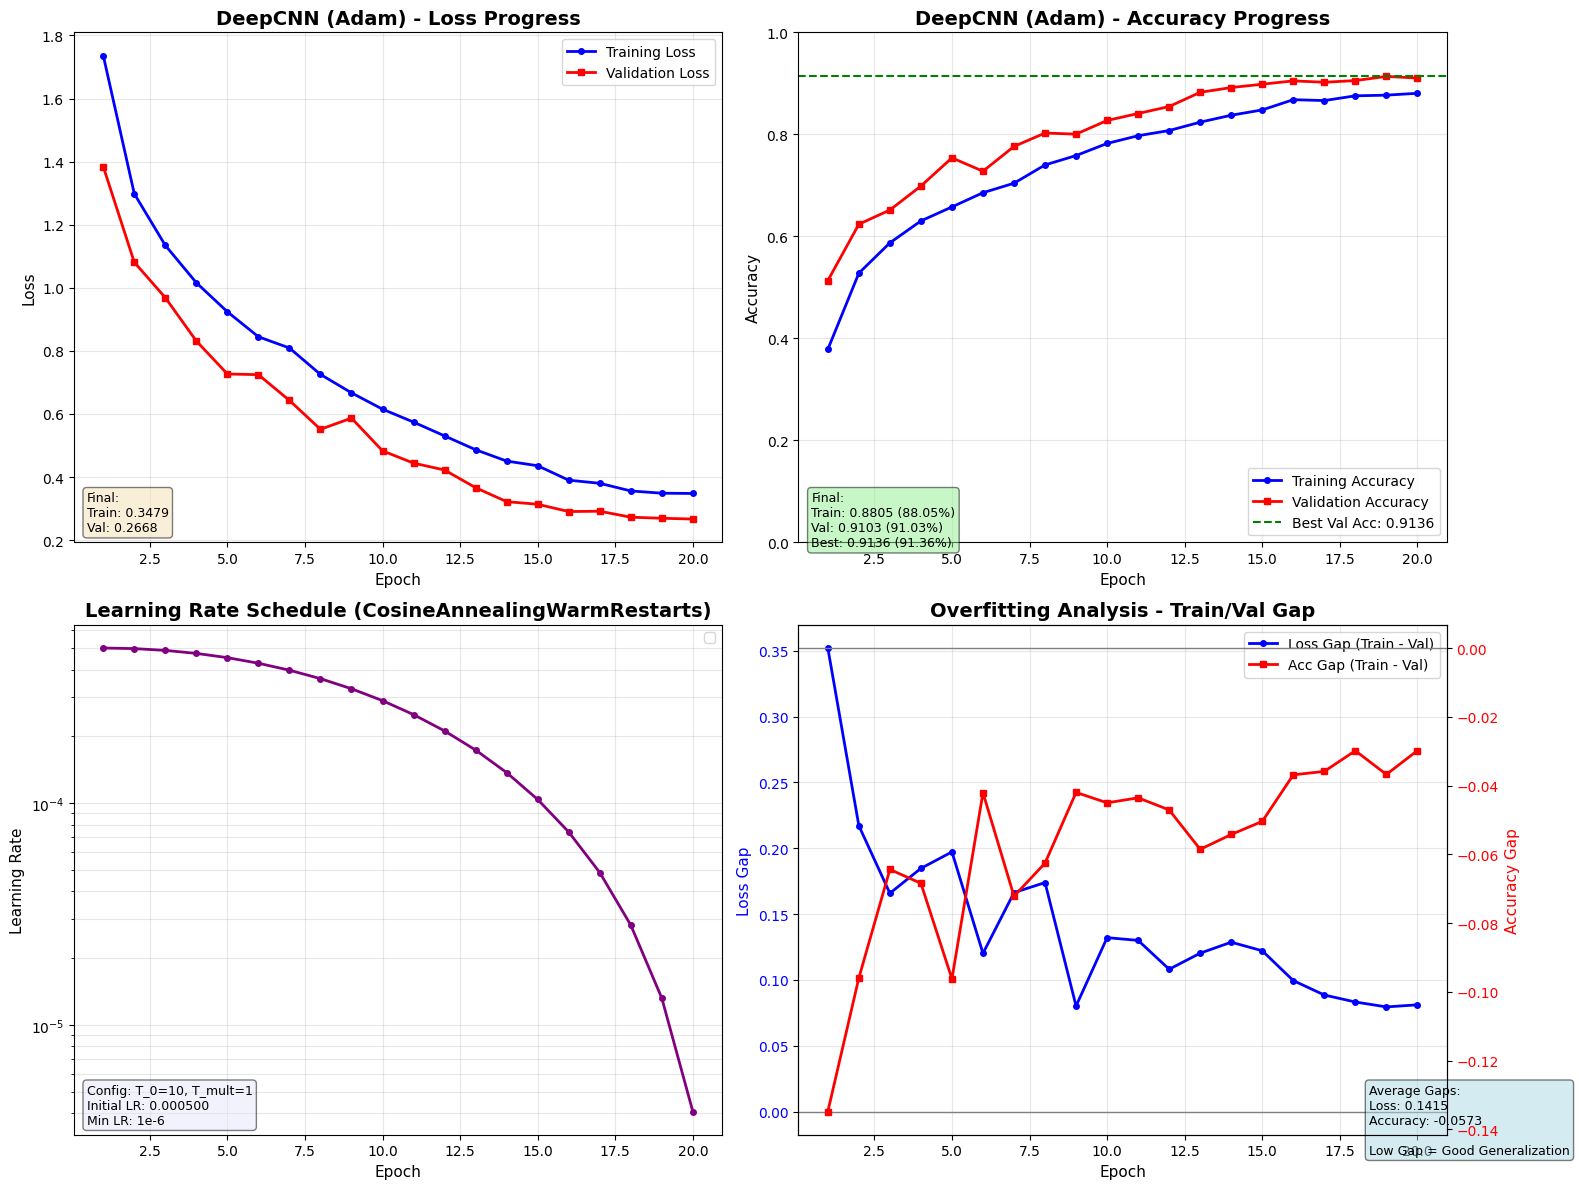

In [54]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

epochs = range(1, len(adam_history['train_loss']) + 1)

# Loss Progress
axes[0, 0].plot(epochs, adam_history['train_loss'], '-o', label='Training Loss', linewidth=2, markersize=4, color='blue')
axes[0, 0].plot(epochs, adam_history['val_loss'], '-s', label='Validation Loss', linewidth=2, markersize=4, color='red')
axes[0, 0].set_title('DeepCNN (Adam) - Loss Progress', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch', fontsize=11)
axes[0, 0].set_ylabel('Loss', fontsize=11)
axes[0, 0].legend(loc='upper right')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].text(0.02, 0.10, f'Final:\nTrain: {adam_history["train_loss"][-1]:.4f}\nVal: {adam_history["val_loss"][-1]:.4f}',
                transform=axes[0, 0].transAxes, fontsize=9, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Accuracy Progress
axes[0, 1].plot(epochs, adam_history['train_acc'], '-o', label='Training Accuracy', linewidth=2, markersize=4, color='blue')
axes[0, 1].plot(epochs, adam_history['val_acc'], '-s', label='Validation Accuracy', linewidth=2, markersize=4, color='red')
axes[0, 1].axhline(y=max(adam_history['val_acc']), color='green', linestyle='--', linewidth=1.5, 
                   label=f'Best Val Acc: {max(adam_history["val_acc"]):.4f}')
axes[0, 1].set_title('DeepCNN (Adam) - Accuracy Progress', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch', fontsize=11)
axes[0, 1].set_ylabel('Accuracy', fontsize=11)
axes[0, 1].legend(loc='lower right')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_ylim([0, 1])
axes[0, 1].text(0.02, 0.10, f'Final:\nTrain: {adam_history["train_acc"][-1]:.4f} ({adam_history["train_acc"][-1]*100:.2f}%)\nVal: {adam_history["val_acc"][-1]:.4f} ({adam_history["val_acc"][-1]*100:.2f}%)\nBest: {max(adam_history["val_acc"]):.4f} ({max(adam_history["val_acc"])*100:.2f}%)',
                transform=axes[0, 1].transAxes, fontsize=9, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

# Learning Rate Schedule
axes[1, 0].plot(epochs, adam_history['learning_rates'], '-o', linewidth=2, markersize=4, color='purple')
axes[1, 0].set_title('Learning Rate Schedule (CosineAnnealingWarmRestarts)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch', fontsize=11)
axes[1, 0].set_ylabel('Learning Rate', fontsize=11)
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True, alpha=0.3, which='both')
axes[1, 0].legend()
axes[1, 0].text(0.02, 0.10, f'Config: T_0=10, T_mult=1\nInitial LR: {adam_history["learning_rates"][0]:.6f}\nMin LR: 1e-6',
                transform=axes[1, 0].transAxes, fontsize=9, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='lavender', alpha=0.5))

# Overfitting Analysis - Train/Val Gap
loss_gap = [train - val for train, val in zip(adam_history['train_loss'], adam_history['val_loss'])]
acc_gap = [train - val for train, val in zip(adam_history['train_acc'], adam_history['val_acc'])]

ax_gap = axes[1, 1]
ax_gap.plot(epochs, loss_gap, '-o', label='Loss Gap (Train - Val)', linewidth=2, markersize=4, color='blue')
ax_gap.set_xlabel('Epoch', fontsize=11)
ax_gap.set_ylabel('Loss Gap', fontsize=11, color='blue')
ax_gap.tick_params(axis='y', labelcolor='blue')
ax_gap.grid(True, alpha=0.3)
ax_gap.axhline(y=0, color='gray', linestyle='-', linewidth=1)

ax_gap2 = ax_gap.twinx()
ax_gap2.plot(epochs, acc_gap, '-s', label='Acc Gap (Train - Val)', linewidth=2, markersize=4, color='red')
ax_gap2.set_ylabel('Accuracy Gap', fontsize=11, color='red')
ax_gap2.tick_params(axis='y', labelcolor='red')
ax_gap2.axhline(y=0, color='gray', linestyle='-', linewidth=1)

axes[1, 1].set_title('Overfitting Analysis - Train/Val Gap', fontsize=14, fontweight='bold')
avg_loss_gap = np.mean(loss_gap)
avg_acc_gap = np.mean(acc_gap)
axes[1, 1].text(0.88, 0.10, f'Average Gaps:\nLoss: {avg_loss_gap:.4f}\nAccuracy: {avg_acc_gap:.4f}\n\nLow Gap = Good Generalization',
                transform=axes[1, 1].transAxes, fontsize=9, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5))

lines1, labels1 = ax_gap.get_legend_handles_labels()
lines2, labels2 = ax_gap2.get_legend_handles_labels()
ax_gap.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

plt.tight_layout()
plt.savefig(os.path.join(PART1_DIR, 'adam_training_analysis.png'), dpi=300, bbox_inches='tight')
print(f"Plot saved to {os.path.join(PART1_DIR, 'adam_training_analysis.png')}")
plt.show()

## 12) Test eval (best Adam)

In [55]:
import torch
import numpy as np
import os
import time

def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    preds, labels_all = [], []
    total = len(test_loader.dataset)

    start = time.time()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            _, p = torch.max(outputs, 1)
            preds.extend(p.cpu().numpy())
            labels_all.extend(labels.cpu().numpy())

    test_loss /= total
    test_acc = np.mean(np.array(preds) == np.array(labels_all))

    print(f"test loss: {test_loss:.4f} | test acc: {test_acc:.4f} ({test_acc*100:.2f}%)")
    return test_loss, test_acc, preds, labels_all


# Load and evaluate the best model
best_model_path = os.path.join(MODELS_DIR, 'best_model_WasteCustom_Adam.pth')
print(f"loading: {best_model_path}")

best_model = WasteCustom(num_classes=NUM_CLASSES).to(DEVICE)
best_model.load_state_dict(torch.load(best_model_path))

test_loss, test_acc, predictions, true_labels = evaluate_model(best_model, test_loader, criterion, DEVICE)

correct = np.sum(np.array(predictions) == np.array(true_labels))
incorrect = len(true_labels) - correct
print(f"samples: {len(true_labels)} | correct: {correct} | wrong: {incorrect}")

loading: results\models\best_model_WasteCustom_Adam.pth
test loss: 0.2570 | test acc: 0.9247 (92.47%)
samples: 1859 | correct: 1719 | wrong: 140


## 13) Confusion matrix

Confusion matrix saved to results\part1\confusion_matrix_adam.png


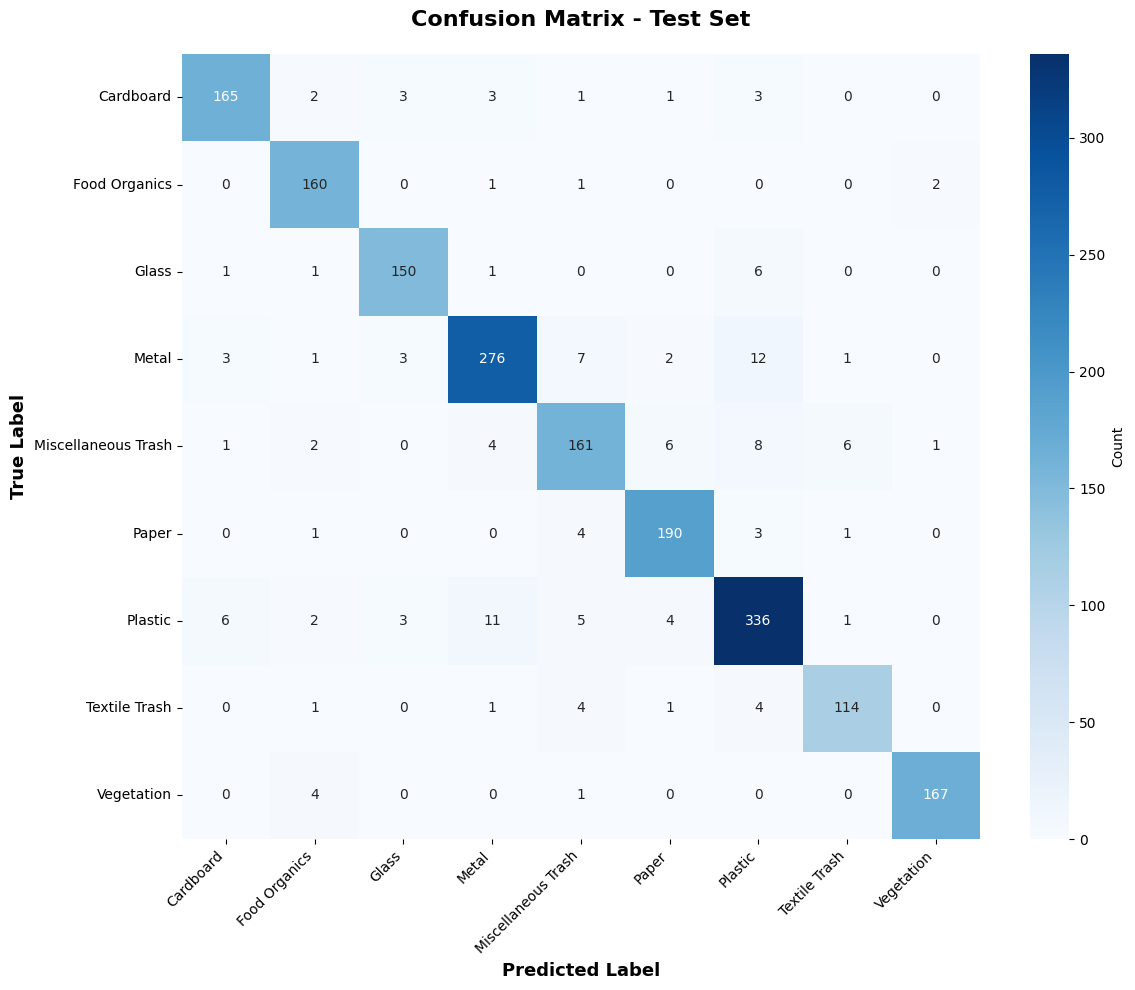

CONFUSION MATRIX ANALYSIS
Cardboard                : 165/178 correct (92.70%)
Food Organics            : 160/164 correct (97.56%)
Glass                    : 150/159 correct (94.34%)
Metal                    : 276/305 correct (90.49%)
Miscellaneous Trash      : 161/189 correct (85.19%)
Paper                    : 190/199 correct (95.48%)
Plastic                  : 336/368 correct (91.30%)
Textile Trash            : 114/125 correct (91.20%)
Vegetation               : 167/172 correct (97.09%)


In [56]:
cm = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Test Set', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=13, fontweight='bold')
plt.ylabel('True Label', fontsize=13, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig(os.path.join(PART1_DIR, 'confusion_matrix_adam.png'), dpi=300, bbox_inches='tight')
print(f"Confusion matrix saved to {os.path.join(PART1_DIR, 'confusion_matrix_adam.png')}")
plt.show()


print('CONFUSION MATRIX ANALYSIS')

for i, cls in enumerate(class_names):
    total = cm[i].sum()
    correct = cm[i, i]
    accuracy = correct / total if total > 0 else 0
    print(f'{cls:25s}: {correct:3d}/{total:3d} correct ({accuracy*100:5.2f}%)')

## 14) Classification report

In [57]:
print('='*70)
print('CLASSIFICATION REPORT')
print('='*70)
print(classification_report(true_labels, predictions, target_names=class_names, digits=4))

from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(true_labels, predictions, average=None)

metrics_df = {
    'Class': class_names,
    'Precision': [f'{p:.4f}' for p in precision],
    'Recall': [f'{r:.4f}' for r in recall],
    'F1-Score': [f'{f:.4f}' for f in f1],
    'Support': support
}

print('\n' + '='*70)
print('PER-CLASS METRICS SUMMARY')
print('='*70)
for i in range(len(class_names)):
    print(f'{metrics_df["Class"][i]:25s} | P: {metrics_df["Precision"][i]} | R: {metrics_df["Recall"][i]} | F1: {metrics_df["F1-Score"][i]} | Support: {metrics_df["Support"][i]:3d}')
print('='*70)

CLASSIFICATION REPORT
                     precision    recall  f1-score   support

          Cardboard     0.9375    0.9270    0.9322       178
      Food Organics     0.9195    0.9756    0.9467       164
              Glass     0.9434    0.9434    0.9434       159
              Metal     0.9293    0.9049    0.9169       305
Miscellaneous Trash     0.8750    0.8519    0.8633       189
              Paper     0.9314    0.9548    0.9429       199
            Plastic     0.9032    0.9130    0.9081       368
      Textile Trash     0.9268    0.9120    0.9194       125
         Vegetation     0.9824    0.9709    0.9766       172

           accuracy                         0.9247      1859
          macro avg     0.9276    0.9282    0.9277      1859
       weighted avg     0.9247    0.9247    0.9246      1859


PER-CLASS METRICS SUMMARY
Cardboard                 | P: 0.9375 | R: 0.9270 | F1: 0.9322 | Support: 178
Food Organics             | P: 0.9195 | R: 0.9756 | F1: 0.9467 | Support: 164

## 15) Per-class metrics

Performance metrics plot saved to results\part1\performance_metrics.png


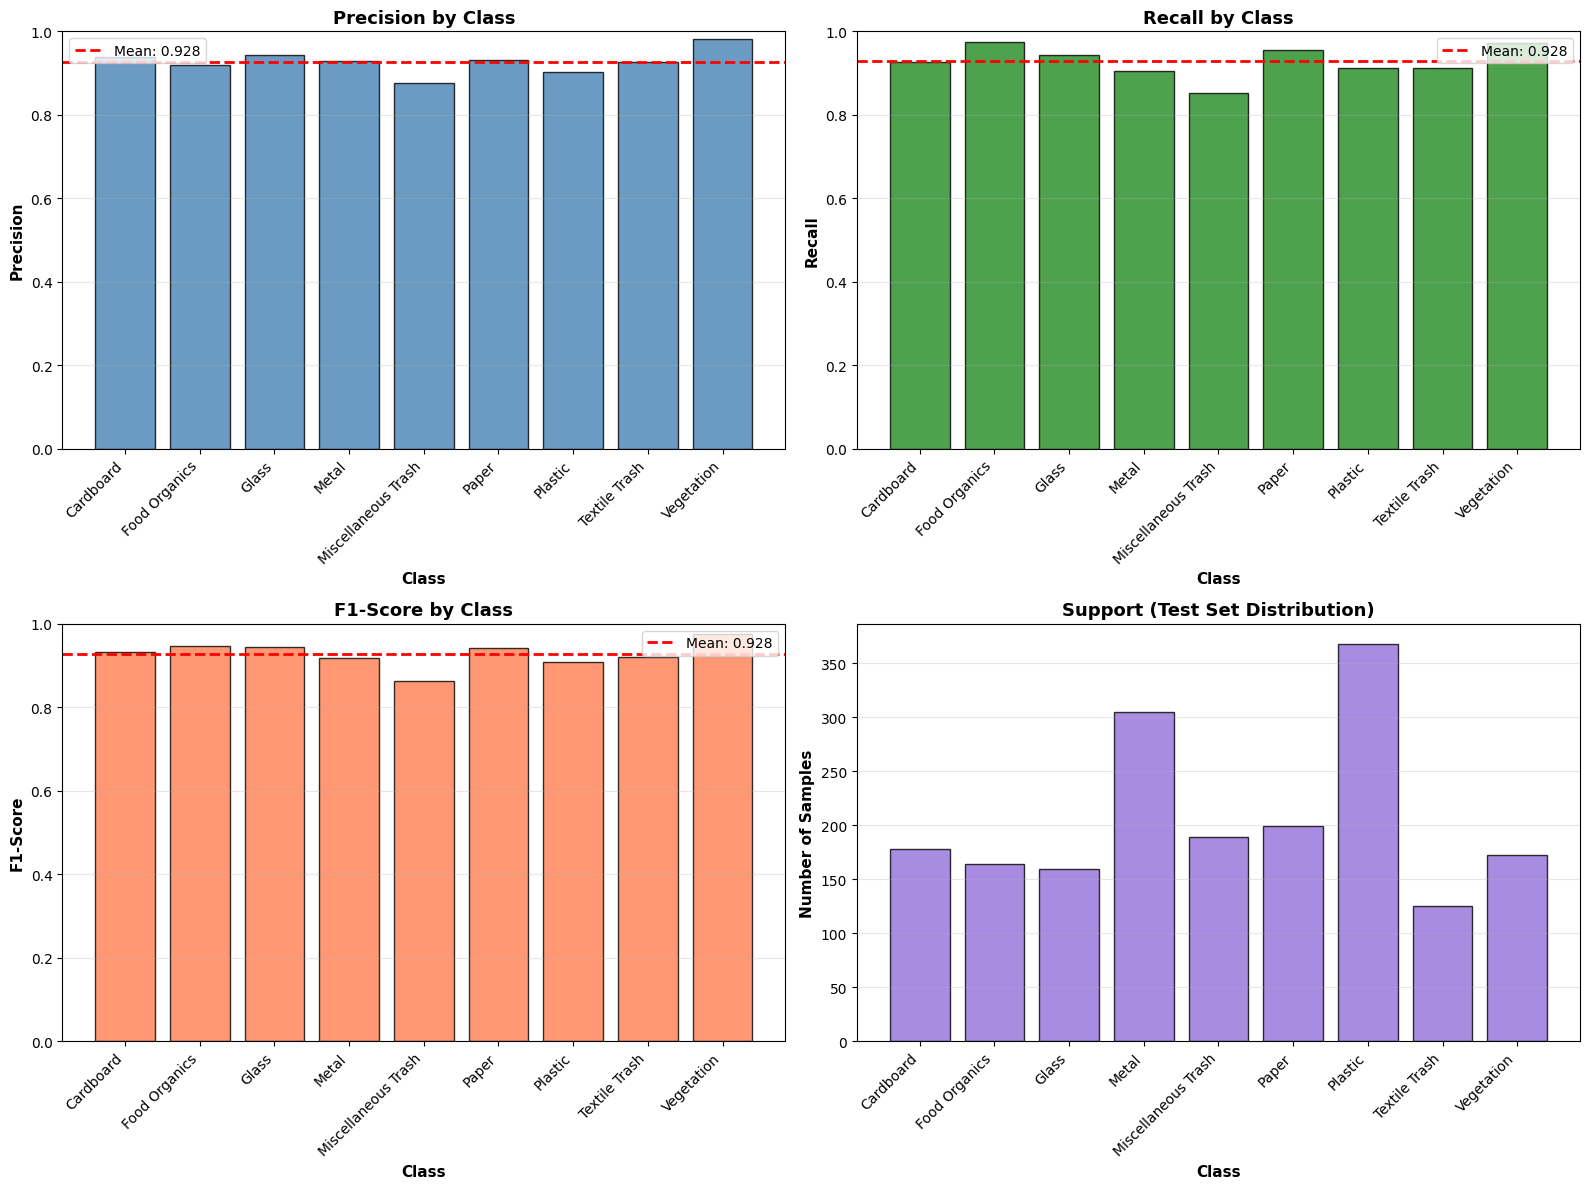

In [58]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

x_pos = np.arange(len(class_names))

# Precision
axes[0, 0].bar(x_pos, precision, color='steelblue', alpha=0.8, edgecolor='black')
axes[0, 0].set_xlabel('Class', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Precision', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Precision by Class', fontsize=13, fontweight='bold')
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(class_names, rotation=45, ha='right')
axes[0, 0].set_ylim([0, 1])
axes[0, 0].grid(axis='y', alpha=0.3)
axes[0, 0].axhline(y=np.mean(precision), color='r', linestyle='--', linewidth=2, label=f'Mean: {np.mean(precision):.3f}')
axes[0, 0].legend()

# Recall
axes[0, 1].bar(x_pos, recall, color='forestgreen', alpha=0.8, edgecolor='black')
axes[0, 1].set_xlabel('Class', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Recall', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Recall by Class', fontsize=13, fontweight='bold')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(class_names, rotation=45, ha='right')
axes[0, 1].set_ylim([0, 1])
axes[0, 1].grid(axis='y', alpha=0.3)
axes[0, 1].axhline(y=np.mean(recall), color='r', linestyle='--', linewidth=2, label=f'Mean: {np.mean(recall):.3f}')
axes[0, 1].legend()

# F1-Score
axes[1, 0].bar(x_pos, f1, color='coral', alpha=0.8, edgecolor='black')
axes[1, 0].set_xlabel('Class', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('F1-Score', fontsize=11, fontweight='bold')
axes[1, 0].set_title('F1-Score by Class', fontsize=13, fontweight='bold')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(class_names, rotation=45, ha='right')
axes[1, 0].set_ylim([0, 1])
axes[1, 0].grid(axis='y', alpha=0.3)
axes[1, 0].axhline(y=np.mean(f1), color='r', linestyle='--', linewidth=2, label=f'Mean: {np.mean(f1):.3f}')
axes[1, 0].legend()

# Support (Test Set Distribution)
axes[1, 1].bar(x_pos, support, color='mediumpurple', alpha=0.8, edgecolor='black')
axes[1, 1].set_xlabel('Class', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Number of Samples', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Support (Test Set Distribution)', fontsize=13, fontweight='bold')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(class_names, rotation=45, ha='right')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(PART1_DIR, 'performance_metrics.png'), dpi=300, bbox_inches='tight')
print(f"Performance metrics plot saved to {os.path.join(PART1_DIR, 'performance_metrics.png')}")
plt.show()

In [59]:
print('== Adam model (test) ==')
print(f'acc: {test_acc:.4f} | loss: {test_loss:.4f}')
print('top-3 classes by F1:')
best_f1_idx = np.argsort(f1)[-3:][::-1]
for idx in best_f1_idx:
    print(f'  {class_names[idx]} -> F1 {f1[idx]:.4f} (P {precision[idx]:.4f}, R {recall[idx]:.4f})')

print('bottom-3 classes by F1:')
worst_f1_idx = np.argsort(f1)[:3]
for idx in worst_f1_idx:
    print(f'  {class_names[idx]} -> F1 {f1[idx]:.4f} (P {precision[idx]:.4f}, R {recall[idx]:.4f})')

# common confusions (top-5)
misclassifications = []
for i in range(len(class_names)):
    for j in range(len(class_names)):
        if i != j and cm[i, j] > 0:
            misclassifications.append((class_names[i], class_names[j], cm[i, j]))
misclassifications.sort(key=lambda x: x[2], reverse=True)
print('top-5 confusions:')
for true_cls, pred_cls, count in misclassifications[:5]:
    print(f'  {true_cls} -> {pred_cls}: {count}')

== Adam model (test) ==
acc: 0.9247 | loss: 0.2570
top-3 classes by F1:
  Vegetation -> F1 0.9766 (P 0.9824, R 0.9709)
  Food Organics -> F1 0.9467 (P 0.9195, R 0.9756)
  Glass -> F1 0.9434 (P 0.9434, R 0.9434)
bottom-3 classes by F1:
  Miscellaneous Trash -> F1 0.8633 (P 0.8750, R 0.8519)
  Plastic -> F1 0.9081 (P 0.9032, R 0.9130)
  Metal -> F1 0.9169 (P 0.9293, R 0.9049)
top-5 confusions:
  Metal -> Plastic: 12
  Plastic -> Metal: 11
  Miscellaneous Trash -> Plastic: 8
  Metal -> Miscellaneous Trash: 7
  Glass -> Plastic: 6


## 17) Sample predictions

Sample predictions saved to results\part1\sample_predictions.png


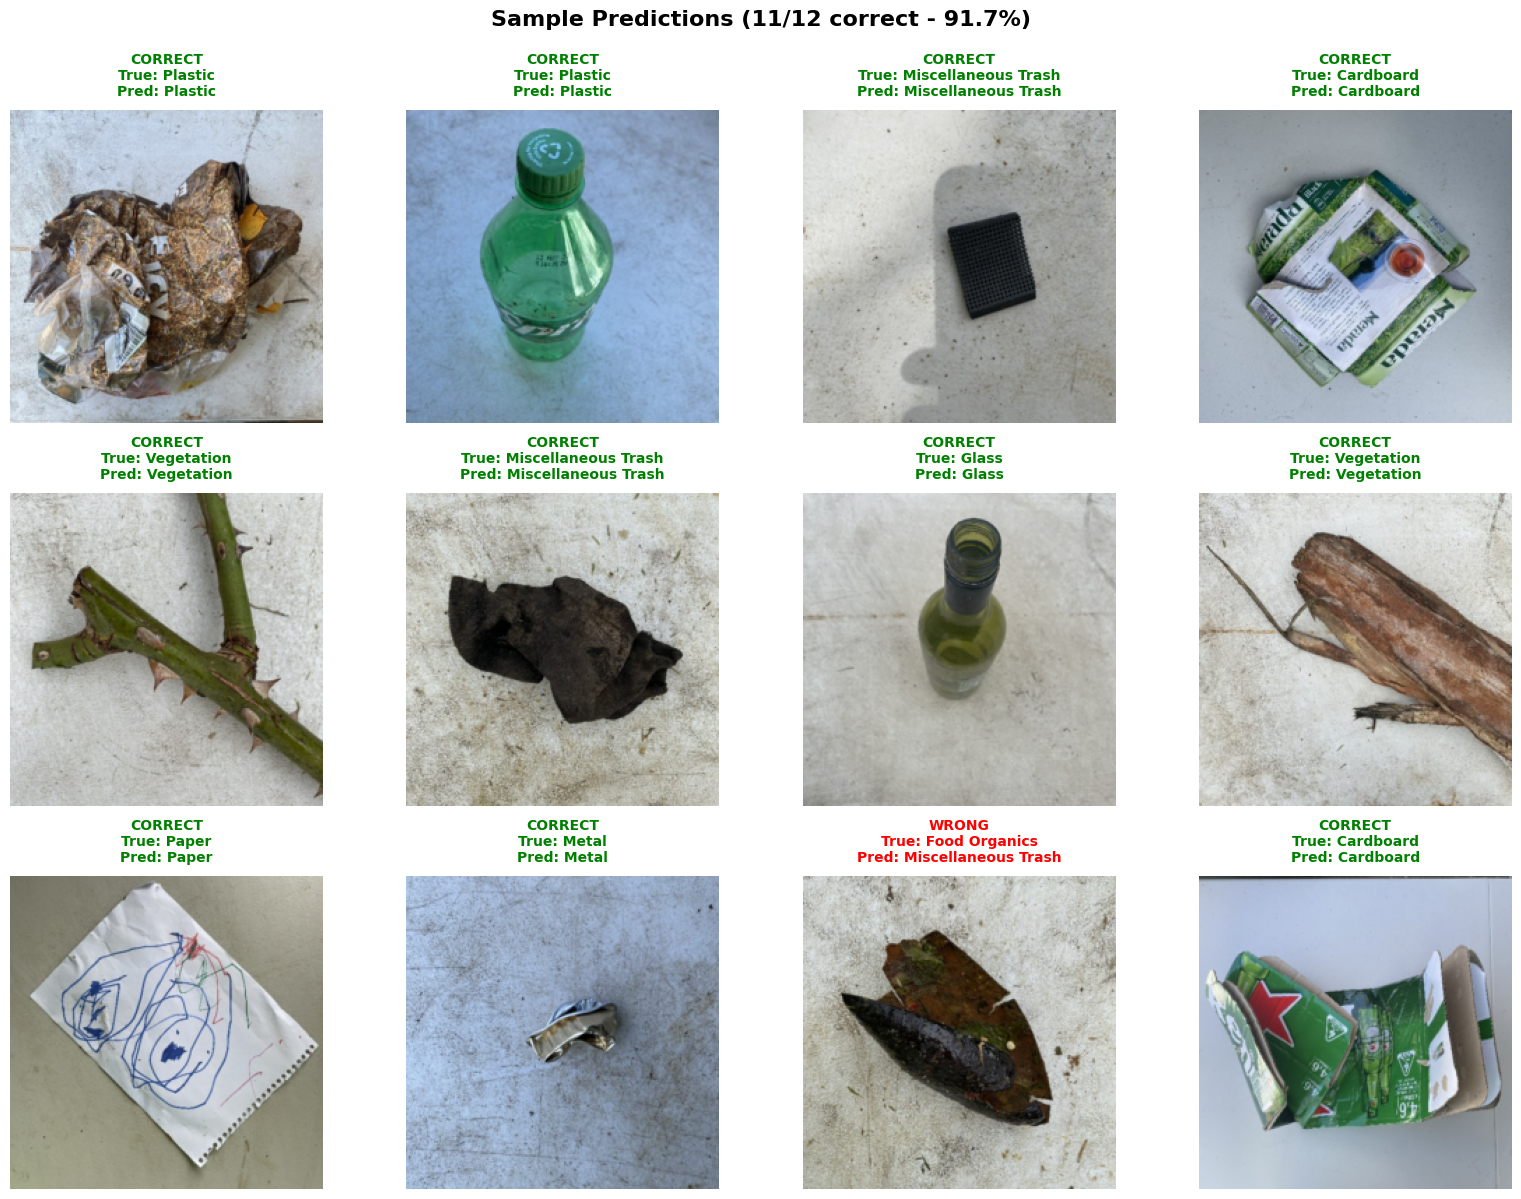

In [60]:
import random

def denormalize(tensor):
    """Denormalize image tensor for visualization"""
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    tensor = tensor * std + mean
    tensor = torch.clamp(tensor, 0, 1)
    return tensor

def show_predictions(model, test_dataset, class_names, device, num_samples=12):
    model.eval()
    indices = random.sample(range(len(test_dataset)), num_samples)

    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.ravel()

    correct_count = 0

    with torch.no_grad():
        for i, idx in enumerate(indices):
            image, true_label = test_dataset[idx]
            image_input = image.unsqueeze(0).to(device)

            output = model(image_input)
            _, predicted = torch.max(output, 1)
            pred_label = predicted.item()

            img_display = denormalize(image).permute(1, 2, 0).cpu().numpy()

            axes[i].imshow(img_display)
            axes[i].axis('off')

            is_correct = (pred_label == true_label)
            if is_correct:
                correct_count += 1
                color = 'green'
                status = 'CORRECT'
            else:
                color = 'red'
                status = 'WRONG'

            axes[i].set_title(f'{status}\nTrue: {class_names[true_label]}\nPred: {class_names[pred_label]}', 
                            color=color, fontsize=10, fontweight='bold', pad=10)

    plt.suptitle(f'Sample Predictions ({correct_count}/{num_samples} correct - {correct_count/num_samples*100:.1f}%)',
                 fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig(os.path.join(PART1_DIR, 'sample_predictions.png'), dpi=300, bbox_inches='tight')
    print(f"Sample predictions saved to {os.path.join(PART1_DIR, 'sample_predictions.png')}")
    plt.show()

# Get the test dataset (without DataLoader)
from torchvision import datasets, transforms
test_transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_dataset = datasets.ImageFolder(
    root=os.path.join(SPLIT_DATA_DIR, 'test'),
    transform=test_transform
)

show_predictions(best_model, test_dataset, class_names, DEVICE, num_samples=12)